# Introduction

The dataset that I have wrangled (and analyzed and visualized) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

## Gathering Data

In [1]:
# Loading necessary libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import requests
import tweepy
from tweepy import OAuthHandler
import json
import sqlite3
import seaborn as sns
from timeit import default_timer as timer

%matplotlib inline

In [2]:
# Reading data from CSV using Pandas library

archive_df = pd.read_csv('twitter-archive-enhanced.csv', encoding='utf-8')
archive_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [3]:
# Import the data programmatically using 'requests'
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

# Save the data into a file called 'image_predictions.tsv'
with open ('image_predictions.tsv', 'wb') as file:
    file.write(r.content)

# Read the file using tab as a seperator
image_predictions_df = pd.read_table('image_predictions.tsv', sep = '\t')

# Show the header
image_predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1923,857029823797047296,https://pbs.twimg.com/media/C-TIEwMW0AEjb55.jpg,2,golden_retriever,0.968623,True,Labrador_retriever,0.010325,True,Saluki,0.004148,True
1513,786595970293370880,https://pbs.twimg.com/media/CuqM0fVWAAAboKR.jpg,1,Pembroke,0.709512,True,Cardigan,0.287178,True,chow,0.000570,True
839,694356675654983680,https://pbs.twimg.com/media/CaLZtmsWQAApbFw.jpg,1,hamster,0.429871,False,Pomeranian,0.144272,True,pretzel,0.127220,False
1758,825535076884762624,https://pbs.twimg.com/media/C3TjvitXAAAI-QH.jpg,1,Rottweiler,0.681495,True,Tibetan_mastiff,0.147940,True,black-and-tan_coonhound,0.024525,True
1909,852912242202992640,https://pbs.twimg.com/media/C9YnKK3VoAAxn1E.jpg,1,Great_Dane,0.783765,True,Rhodesian_ridgeback,0.114147,True,English_foxhound,0.046440,True


In [4]:
# Storing tweet ids into a new dataframe
tweet_ids = archive_df['tweet_id']

In [5]:
# Total number of Tweets
len(tweet_ids)

2356

In [6]:
# Connecting twitter API to download data

consumer_key = 'pGig8fbpkRcc4LSOjk6id2zKK'
consumer_secret = 'mNWOl5CEZZmkkmlpRYd1C8KmIERWniVf08X4tx7ieaC5o19w4L'
access_token = '1257837009755832321-rDyX7AIXkIJS3EeV7Nr7pCPrAnbqZx'
access_secret = 'nC6XKTsYzVS9A6tBs7Hg4SViraycvh4KGDL0TltrHYQwk'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Storing data from Twitter API in a list

tweet_ids = list(archive_df.tweet_id)
tweet_data = {}
fails_dict = {}
start = timer()
count = 0
for tweet_id in tweet_ids:
    count += 1
    print(str(count) + ": " + str(tweet_id))
    try:
        tweet_status = api.get_status(tweet_id, tweet_mode='extended')         
        tweet_data[str(tweet_id)] = tweet_status._json
        print("Success")
    except tweepy.TweepError as e:
        print("Error")
        fails_dict[str(tweet_id)] = e

end = timer()
print(end - start)
print(fails_dict)

# Number of tweets for which data was not fetched
len(fails_dict)

#Writing the data into text file
with open('tweet_json.txt', 'w') as file:
    json.dump(tweet_data, file)

In [7]:
#Reading the text file in json format
with open('tweet_json.txt') as file:
    data = json.load(file)
    
tweets_info_list = []
for tweet_id in data.keys():
    retweets = data[tweet_id]['retweet_count']
    favourites = data[tweet_id]['favorite_count']
    tweets_info_list.append({'tweet_id': tweet_id, 'retweets' : retweets,'favorites': favourites})
    
tweets_info_df = pd.DataFrame(tweets_info_list, columns = ['tweet_id', 'retweets', 'favorites'])
tweets_info_df.sample(5)

,tweet_id,retweets,favorites
2279,666983947667116034,929,2441
844,762035686371364864,15717,32239
426,819588359383371776,2028,9808
2246,667495797102141441,254,502
2303,666396247373291520,76,159


In [8]:
# Check for duplicate rows
tweets_info_df['tweet_id'].duplicated().sum()

0

### Final Gathered Data consists of below dataframes - 

1. archive_df - This dataframe contains details of all the tweets.
2. tweets_info_df - This dataframe contains tweet_id, number of retweets, and number of favorites for each tweet. The data is downloaded using Twitter API
3. image_prediction_df - This dataframe contains information about predictions of the image. It is downloaded from the URL provided.

## Assessing the Data

In [9]:
# Display the archive_df table
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
# Display all columns in archive_df table
for i,v in enumerate(archive_df.columns):
    print(i,v)

0 tweet_id
1 in_reply_to_status_id
2 in_reply_to_user_id
3 timestamp
4 source
5 text
6 retweeted_status_id
7 retweeted_status_user_id
8 retweeted_status_timestamp
9 expanded_urls
10 rating_numerator
11 rating_denominator
12 name
13 doggo
14 floofer
15 pupper
16 puppo


The detailed description of each column can be found on this link --> https://sfm.readthedocs.io/en/1.4.3/data_dictionary.html

In [11]:
#Checking the descriptive statistics 
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
#Checking the datatypes
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
# Checking the missing values
archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [14]:
#Checking for duplicates
archive_df[archive_df.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [15]:
archive_df[archive_df['name'] == 'officially']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1747,679111216690831360,NaN,NaN,2015-12-22 01:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is officially the greatest yawn of all ti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679111216...,12,10,officially,None,None,None,None


In [16]:
#Checking the rating values for numerator 
archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [17]:
#Checking the rating values for  denominator
archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
#identify the rating with denominator 0
archive_df[archive_df['rating_denominator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [19]:
#Checking the dog names
dog_names_list = []
dog_names_list = archive_df['name'].unique()
dog_names_list.sort()
dog_names_list

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

In [20]:
#Check for complete text for first entry
archive_df['text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

Quality assessment of archive_df dataframe - 

1. There are missing values in columns - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id , retweeted_status_user_id, retweeted_status_timestamp, expanded_urls

2. rating_numerator and rating_denominator has inconsistent values.

3. One of the tweet (tweet_id = 835246439529840640) has denominator rating of 0

4. Dog names consists of filler words like 'a', 'actually', 'all', 'an', 'by', 'getting','his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very'

5. Datatype of timestamp and retweeted_status_timestamp should be DateTime. It is currently string.

6. Datatypes of in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id must be integer. It is currently float.

7. In columns doggo, floofer, pupper , puppo, there are some missing values represented by None.


Tidiness assessment of archive_df dataframe - 
1. Some attributes like Number of Favorites and Number of Retweet are in seperate dataframe. It should be merged in this dataframe.

In [21]:
# Display the tweets_info_df  table
tweets_info_df.head(5)

,tweet_id,retweets,favorites
0,892420643555336193,7728,36308
1,892177421306343426,5720,31305
2,891815181378084864,3785,23577
3,891689557279858688,7889,39613
4,891327558926688256,8508,37821


In [22]:
tweets_info_df.columns

Index(['tweet_id', 'retweets', 'favorites'], dtype='object')

In [23]:
#Checking the descriptive statistics 
tweets_info_df.describe()

,retweets,favorites
count,2331.000000,2331.000000
mean,2712.767482,7584.075075
std,4588.005730,11769.698123
min,1.000000,0.000000
25%,548.500000,1323.000000
50%,1273.000000,3299.000000
75%,3151.500000,9293.500000
max,78104.000000,156721.000000


In [24]:
#Checking the datatypes
tweets_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2331 non-null   object
 1   retweets   2331 non-null   int64 
 2   favorites  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


In [25]:
#Checking missing values
tweets_info_df.isnull().sum()

tweet_id     0
retweets     0
favorites    0
dtype: int64

In [26]:
#Checking for duplicates
tweets_info_df[tweets_info_df.tweet_id.duplicated()]

,tweet_id,retweets,favorites


Quality assessment of tweets_info dataframe - 

1. Information for 25 tweets is not available when downloaded from twitter API


Tidiness assessment of tweets_info dataframe - 
1. Attributes like Number of Favorites and Number of Retweet in this dataframe should be merged with archive_df dataframe which has other attributes of the tweet.

In [27]:
# Display the image predictions table
image_predictions_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [28]:
image_predictions_df.shape

(2075, 12)

In [29]:
image_predictions_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [30]:
#Checking for duplicates
image_predictions_df[image_predictions_df.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [31]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [32]:
image_predictions_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

Quality and tidiness assessment of image_predictions_df dataframe - 

1. Data is clean with no missing values.
2. Predictions are available for 2075 tweets.
3. Prediction output will be merged with archive_df dataframe so that all the details are captured in a single dataframe.

## Cleaning Dataset

For cleaning the dataset, define-code-test approach is used.

#### Define

Create the copy of each dataframe so that original dataframe is retained

#### Code

In [33]:
archive_clean = archive_df.copy()
tweets_clean = tweets_info_df.copy()
img_pred_clean = image_predictions_df.copy()

#### Test

In [34]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [35]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2331 non-null   object
 1   retweets   2331 non-null   int64 
 2   favorites  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


In [36]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Define

Convert datatype of tweet_id in all the dataframes to string

#### Code

In [37]:
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype(str)
img_pred_clean['tweet_id'] = img_pred_clean['tweet_id'].astype(str)
tweets_clean['tweet_id'] = tweets_clean['tweet_id'].astype(str)

#### Test

In [38]:
archive_clean.dtypes

tweet_id                       object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [39]:
img_pred_clean.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [40]:
tweets_clean.dtypes

tweet_id     object
retweets      int64
favorites     int64
dtype: object

#### Define

Merge attributes from tweets_clean and img_pred_clean in archive_clean by using a inner join with tweet_id as unique key.

#### Code

In [41]:
archive_clean = pd.merge(archive_clean, tweets_clean, how = 'inner', on = 'tweet_id')
archive_clean = pd.merge(archive_clean, img_pred_clean, how = 'inner', on = 'tweet_id')

#### Test

In [42]:
archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
557,785533386513321988,NaN,NaN,2016-10-10 17:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dallas. Her tongue is ridiculous. 11/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785533386...,...,2,miniature_pinscher,0.436023,True,black-and-tan_coonhound,0.258049,True,Rottweiler,0.145231,True
1945,667915453470232577,NaN,NaN,2015-11-21 04:00:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Otis. He is a Peruvian Quartzite. Pic spo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667915453...,...,1,leatherback_turtle,0.452517,False,boxer,0.196655,True,terrapin,0.160983,False
1448,680115823365742593,NaN,NaN,2015-12-24 20:00:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ozzy. He woke up 2 minutes before he h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680115823...,...,1,pug,0.999365,True,French_bulldog,0.000544,True,Boston_bull,0.000028,True
1826,670417414769758208,NaN,NaN,2015-11-28 01:42:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Sharp dog here. Introverted. Loves purple. Not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670417414...,...,1,sea_urchin,0.493257,False,porcupine,0.460565,False,cardoon,0.008146,False
59,879415818425184262,NaN,NaN,2017-06-26 19:07:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879415818...,...,1,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True


In [43]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   object 
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2059 non-null   object 
 4   source                      2059 non-null   object 
 5   text                        2059 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2059 non-null   object 
 10  rating_numerator            2059 non-null   int64  
 11  rating_denominator          2059 non-null   int64  
 12  name                        2059 non-null   object 
 13  doggo                       2059 

In [44]:
archive_clean.shape

(2059, 30)

In [45]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'retweets', 'favorites', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

#### Define

Convert different dog categories (doggo, floffer, pupper, puppo) into one column

#### Code

In [46]:
archive_clean = pd.melt(archive_clean,
                        id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
                           'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
                           'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
                           'rating_denominator', 'name', 
                           'retweets', 'favorites', 'jpg_url', 'img_num',
                           'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
                           'p3_dog'],
                        value_name='dog_stage')

In [47]:
archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,variable,dog_stage
1662,673656262056419329,NaN,NaN,2015-12-07 00:12:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Albert AKA King Banana Peel. He's a ki...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673656262...,...,0.700625,True,Rhodesian_ridgeback,0.094698,True,Brabancon_griffon,0.057559,True,doggo,None
8088,668631377374486528,NaN,NaN,2015-11-23 03:25:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Zeek. He is a grey Cumulonimbus. Zeek is ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668631377...,...,0.904549,True,Australian_terrier,0.022529,True,silky_terrier,0.015243,True,puppo,None
5040,728986383096946689,NaN,NaN,2016-05-07 16:34:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Puff. He started out on the streets (f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/728986383...,...,0.952070,True,toy_poodle,0.027271,True,miniature_poodle,0.004874,True,pupper,None
8189,666804364988780544,NaN,NaN,2015-11-18 02:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jockson. He is a Pinnacle Sagittarius....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666804364...,...,0.328792,True,Brittany_spaniel,0.283545,True,Ibizan_hound,0.057461,True,puppo,None
1086,706681918348251136,NaN,NaN,2016-03-07 03:24:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Katie. She's a Mitsubishi Hufflep...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706681918...,...,0.717584,True,miniature_poodle,0.151433,True,Norwich_terrier,0.047087,True,doggo,None


In [48]:
archive_clean['dog_stage'].value_counts()

None       7905
pupper      221
doggo        78
puppo        24
floofer       8
Name: dog_stage, dtype: int64

In [49]:
archive_clean['variable'].value_counts()

pupper     2059
doggo      2059
floofer    2059
puppo      2059
Name: variable, dtype: int64

In [50]:
archive_clean.drop(['variable'], axis=1,inplace= True)

In [51]:
archive_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None


In [52]:
archive_clean = archive_clean.drop_duplicates()

In [53]:
archive_clean.shape

(2390, 27)

In [54]:
archive_clean['tweet_id'].duplicated().sum()

331

In [55]:
archive_clean['dog_stage'].value_counts()

None       2059
pupper      221
doggo        78
puppo        24
floofer       8
Name: dog_stage, dtype: int64

In [56]:
# Identify the duplicate rows at tweet_id and dog_stage combination
dup_tweet_dog_stage = archive_clean.drop_duplicates(subset=['tweet_id', 'dog_stage']) 
dup_tweet_dog_stage.shape

(2390, 27)

In [57]:
# Selecting the rows with dog_stage with out "None"
dup_tweet_dog_stage_1 = dup_tweet_dog_stage[dup_tweet_dog_stage['dog_stage'] != 'None']
dup_tweet_dog_stage_1.shape

(331, 27)

In [58]:
dup_tweet_dog_stage_1['tweet_id'].value_counts().head(5)

808106460588765185    2
785639753186217984    2
817777686764523521    2
741067306818797568    2
801115127852503040    2
Name: tweet_id, dtype: int64

In [59]:
#Checking the multiple rows information with different dog_stage
dup_tweet_dog_stage_1[dup_tweet_dog_stage_1['tweet_id'] == '817777686764523521']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
357,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,...,curly-coated_retriever,0.733256,True,flat-coated_retriever,0.214145,True,Irish_water_spaniel,0.029769,True,doggo
4475,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,...,curly-coated_retriever,0.733256,True,flat-coated_retriever,0.214145,True,Irish_water_spaniel,0.029769,True,pupper


In [60]:
#Checking the multiple rows information with different dog_stage and its text , this will help in analyzing if text can help
dup_tweet_dog_stage_1[dup_tweet_dog_stage_1['tweet_id'] == '817777686764523521']['text']

357     This is Dido. She's playing the lead role in "...
4475    This is Dido. She's playing the lead role in "...
Name: text, dtype: object

In [61]:
# making a bool series 
bool_series = dup_tweet_dog_stage_1["tweet_id"].duplicated(keep = False) 
  
# bool series 
bool_series 
  
# passing NOT of bool series to see unique values only 
dup_tweet_dog_stage_1 = dup_tweet_dog_stage_1[~bool_series]

In [62]:
dup_tweet_dog_stage_1.shape

(305, 27)

In [63]:
dup_tweet_dog_stage_1.tweet_id.duplicated().sum()

0

In [64]:
# Keeping the random row which has dog_stage other than None , it can be any of the dog_stage 
# (Even with valid dog_stage there are duplicates inside it)
dup_tweet_dog_stage_2 = dup_tweet_dog_stage_1.drop_duplicates(subset=['tweet_id'])

In [65]:
dup_tweet_dog_stage_2.shape

(305, 27)

In [66]:
# Combine
dup_df1 = dup_tweet_dog_stage.drop_duplicates(subset = 'tweet_id', keep = False)
dup_df_merged = dup_df1.append(dup_tweet_dog_stage_2)
dup_df_merged.shape

(2046, 27)

#### Test

In [67]:
dup_df_merged.tweet_id.duplicated().sum()

0

In [68]:
dup_df_merged.dog_stage.value_counts()

None       1741
pupper      210
doggo        65
puppo        23
floofer       7
Name: dog_stage, dtype: int64

In [69]:
dup_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 0 to 7053
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2046 non-null   object 
 1   in_reply_to_status_id       22 non-null     float64
 2   in_reply_to_user_id         22 non-null     float64
 3   timestamp                   2046 non-null   object 
 4   source                      2046 non-null   object 
 5   text                        2046 non-null   object 
 6   retweeted_status_id         70 non-null     float64
 7   retweeted_status_user_id    70 non-null     float64
 8   retweeted_status_timestamp  70 non-null     object 
 9   expanded_urls               2046 non-null   object 
 10  rating_numerator            2046 non-null   int64  
 11  rating_denominator          2046 non-null   int64  
 12  name                        2046 non-null   object 
 13  retweets                    2046 

In [70]:
archive_clean = dup_df_merged.copy()

#### Define

Convert following columns into string - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id , retweeted_status_user_id
Convert following columns into datetime - retweeted_status_timestamp, timestamp

#### Code

In [71]:
archive_clean['in_reply_to_status_id'] = archive_clean['in_reply_to_status_id'].astype(str)
archive_clean['in_reply_to_user_id'] = archive_clean['in_reply_to_user_id'].astype(str)
archive_clean['retweeted_status_id'] = archive_clean['retweeted_status_id'].astype(str)
archive_clean['retweeted_status_user_id'] = archive_clean['retweeted_status_user_id'].astype(str)

archive_clean['retweeted_status_timestamp'] = pd.to_datetime(archive_clean['retweeted_status_timestamp']) 
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [72]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 0 to 7053
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2046 non-null   object             
 1   in_reply_to_status_id       2046 non-null   object             
 2   in_reply_to_user_id         2046 non-null   object             
 3   timestamp                   2046 non-null   datetime64[ns, UTC]
 4   source                      2046 non-null   object             
 5   text                        2046 non-null   object             
 6   retweeted_status_id         2046 non-null   object             
 7   retweeted_status_user_id    2046 non-null   object             
 8   retweeted_status_timestamp  70 non-null     datetime64[ns, UTC]
 9   expanded_urls               2046 non-null   object             
 10  rating_numerator            2046 non-null   int64           

#### Define

Dog names consists of filler words like 'a', 'actually', 'all', 'an', 'by', 'getting','his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very'. Change these names to 'None'

#### Code

In [73]:
pd.set_option('display.max_colwidth', None)

In [74]:
archive_clean.text[archive_clean.name =='infuriating']

1037    We 👏🏻 only 👏🏻 rate 👏🏻 dogs. Pls stop sending in non-canines like this Dutch Panda Worm. This is infuriating. 11/10 https://t.co/odfLzBonG2
Name: text, dtype: object

In [75]:
lst = ['a', 'actually', 'all', 'an', 'by', 'getting','his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very']

for word in lst:
    print(archive_clean.text[archive_clean.name == word])

514                                Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
636                    Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
809                    This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
811                      Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
820                          This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2
982                     People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n
992             

In [76]:
for word in lst:    
     archive_clean.name[archive_clean.name == word] = 'None'

C:\Users\17655\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Test

In [77]:
lst = ['a', 'actually', 'all', 'an', 'by', 'getting','his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very']
for word in lst:
    print(archive_clean.text[archive_clean.name == word])

Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)


In [78]:
archive_clean.name.value_counts()[:10]

None       664
Cooper      10
Tucker      10
Charlie     10
Penny       10
Oliver      10
Lucy         9
Bo           8
Sadie        8
Lola         8
Name: name, dtype: int64

#### Define

Column retweeted_status_timestamp has missing values. However, the variable is not too important. Hence, dropping the said column

#### Code

In [79]:
archive_clean.isnull().sum()

tweet_id                         0
in_reply_to_status_id            0
in_reply_to_user_id              0
timestamp                        0
source                           0
text                             0
retweeted_status_id              0
retweeted_status_user_id         0
retweeted_status_timestamp    1976
expanded_urls                    0
rating_numerator                 0
rating_denominator               0
name                             0
retweets                         0
favorites                        0
jpg_url                          0
img_num                          0
p1                               0
p1_conf                          0
p1_dog                           0
p2                               0
p2_conf                          0
p2_dog                           0
p3                               0
p3_conf                          0
p3_dog                           0
dog_stage                        0
dtype: int64

In [80]:
archive_clean.drop(['retweeted_status_timestamp'],axis=1, inplace= True)

#### Test

In [81]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 0 to 7053
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   tweet_id                  2046 non-null   object             
 1   in_reply_to_status_id     2046 non-null   object             
 2   in_reply_to_user_id       2046 non-null   object             
 3   timestamp                 2046 non-null   datetime64[ns, UTC]
 4   source                    2046 non-null   object             
 5   text                      2046 non-null   object             
 6   retweeted_status_id       2046 non-null   object             
 7   retweeted_status_user_id  2046 non-null   object             
 8   expanded_urls             2046 non-null   object             
 9   rating_numerator          2046 non-null   int64              
 10  rating_denominator        2046 non-null   int64              
 11  name             

## Storing the clean dataset in a CSV file

In [82]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analyzing and Visualising the cleaned dataset

In [83]:
for i,v in enumerate(archive_clean.columns):
    print(i,v)

0 tweet_id
1 in_reply_to_status_id
2 in_reply_to_user_id
3 timestamp
4 source
5 text
6 retweeted_status_id
7 retweeted_status_user_id
8 expanded_urls
9 rating_numerator
10 rating_denominator
11 name
12 retweets
13 favorites
14 jpg_url
15 img_num
16 p1
17 p1_conf
18 p1_dog
19 p2
20 p2_conf
21 p2_dog
22 p3
23 p3_conf
24 p3_dog
25 dog_stage


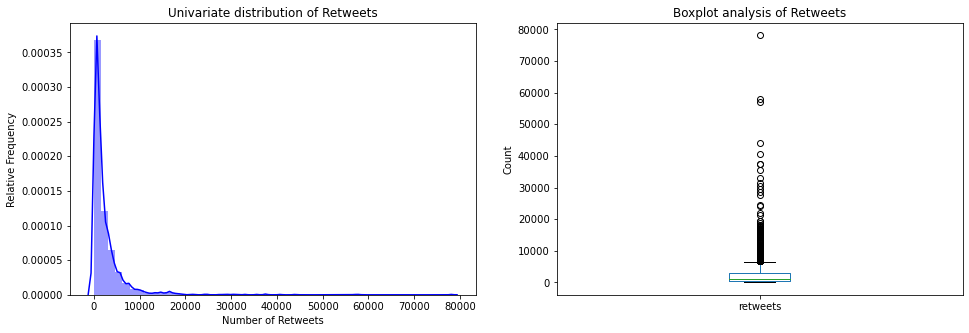

In [84]:
plt.figure(1)
plt.subplot(121)
sns.distplot(archive_clean['retweets'], color = 'blue')
plt.ylabel('Relative Frequency', fontweight="bold")
plt.xlabel('Number of Retweets', fontweight="bold")
plt.title('Univariate distribution of Retweets', fontweight="bold")

plt.subplot(122)
archive_clean['retweets'].plot.box(figsize=(16,5))
plt.ylabel('Count', fontweight="bold")
plt.title('Boxplot analysis of Retweets', fontweight="bold")

plt.show()

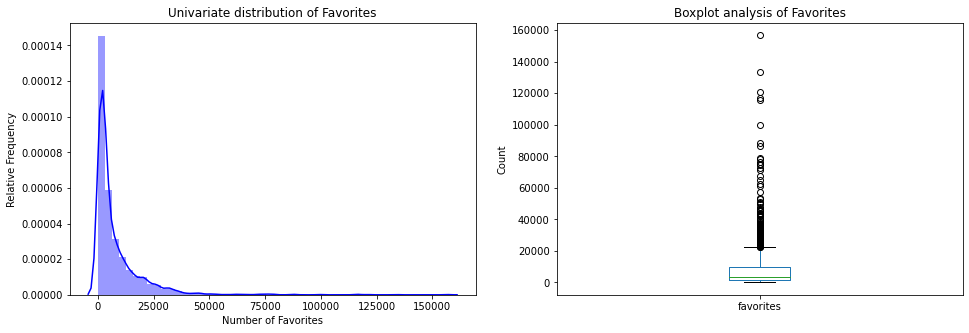

In [85]:
plt.figure(1)
plt.subplot(121)
sns.distplot(archive_clean['favorites'], color = 'blue')
plt.ylabel('Relative Frequency', fontweight="bold")
plt.xlabel('Number of Favorites', fontweight="bold")
plt.title('Univariate distribution of Favorites', fontweight="bold")

plt.subplot(122)
archive_clean['favorites'].plot.box(figsize=(16,5))
plt.ylabel('Count', fontweight="bold")
plt.title('Boxplot analysis of Favorites', fontweight="bold")

plt.show()

In [86]:
# Capping the values to 1 for whichever values <=0
archive_clean['favorites_mod'] = archive_clean.favorites[archive_clean.favorites <= 0] = 1
archive_clean['retweets_mod'] = archive_clean.retweets[archive_clean.retweets <= 0] = 1

C:\Users\17655\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\17655\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'retweets', 'favorites', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'dog_stage', 'favorites_mod', 'retweets_mod'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

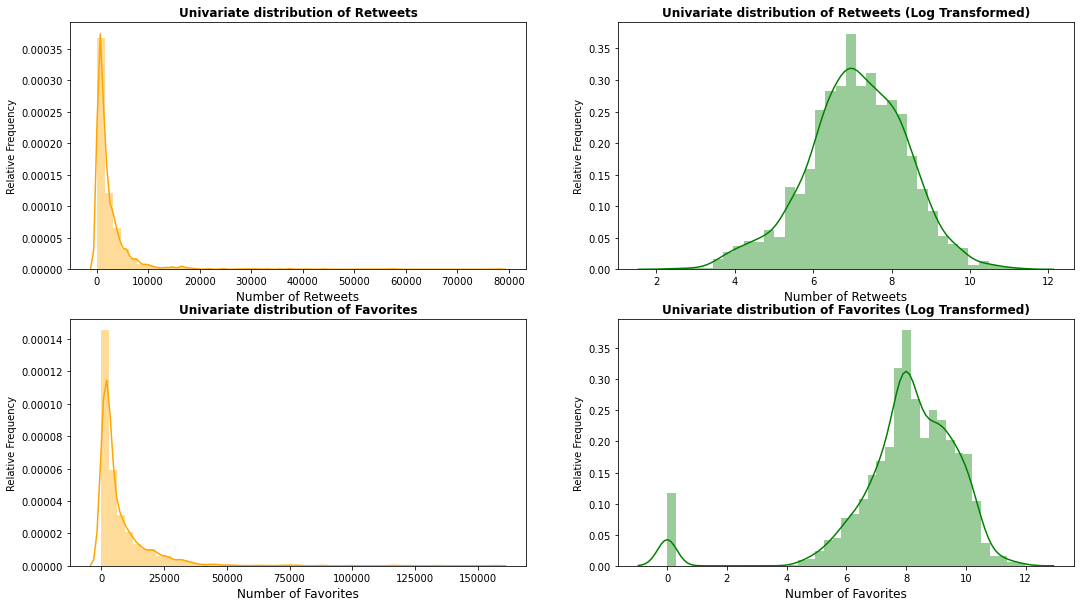

In [117]:
plt.figure(1)
plt.figure(figsize = (18,10))
plt.subplot(221)
sns.distplot(archive_clean.retweets, color = 'orange')
plt.title('Univariate distribution of Retweets', fontweight="bold", fontsize = 12.0)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('Relative Frequency')

plt.subplot(222)
sns.distplot(archive_clean.retweets.apply(np.log), color = 'green')
plt.title('Univariate distribution of Retweets (Log Transformed)', fontweight="bold", fontsize = 12.0)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('Relative Frequency')
                                                                    
plt.subplot(223)
sns.distplot(archive_clean.favorites, color = 'orange')
plt.title('Univariate distribution of Favorites', fontweight="bold", fontsize = 12.0)
plt.xlabel('Number of Favorites', fontsize=12)
plt.ylabel('Relative Frequency')

plt.subplot(224)
sns.distplot(archive_clean.favorites.apply(np.log), color = 'green')
plt.title('Univariate distribution of Favorites (Log Transformed)', fontweight="bold", fontsize = 12.0)
plt.xlabel('Number of Favorites', fontsize=12)
plt.ylabel('Relative Frequency')

plt.show()

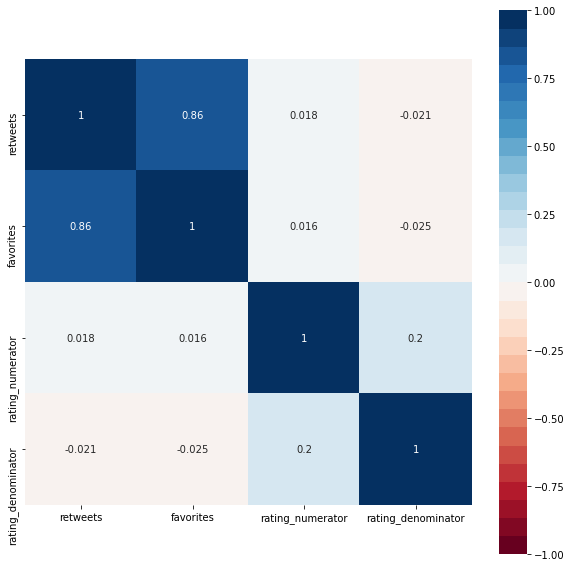

In [110]:
# Correlation between numerical variables
num_cols_data = (archive_clean[['retweets','favorites', 'rating_numerator', 'rating_denominator']])
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(num_cols_data.corr(), vmax=1, vmin=-1, square=True, cmap=plt.cm.get_cmap('RdBu', 30), annot = True);

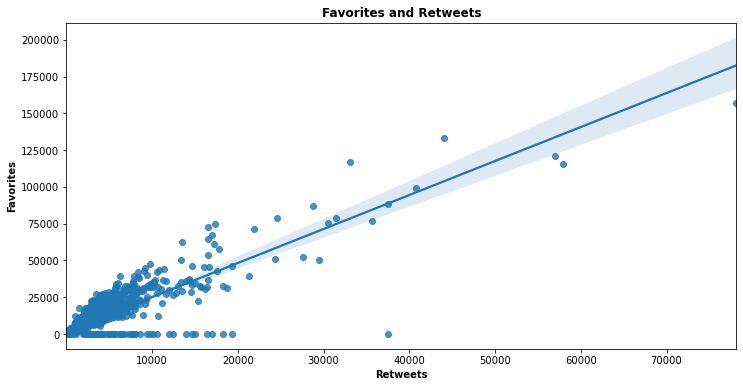

In [118]:
plt.figure(figsize = (12,6))
graph = sns.regplot(x=archive_clean['retweets'], y=archive_clean['favorites'])
plt.title("Favorites and Retweets", fontweight="bold")
plt.xlabel('Retweets', fontweight="bold")
plt.ylabel('Favorites', fontweight="bold")
plt.show()

Retweets and Favorites are highly correlated with each other

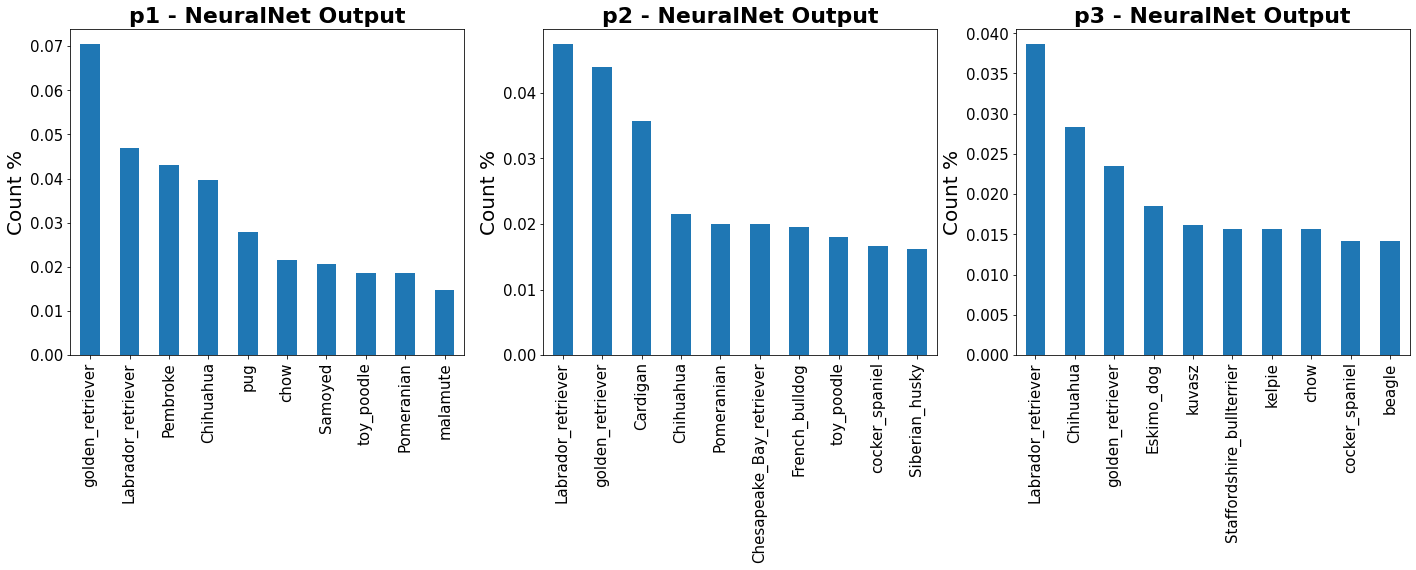

In [91]:
plt.figure(1)
plt.subplot(131)

archive_clean['p1'].value_counts(normalize=True).head(10).plot.bar(figsize=(24,6), fontsize = 15.0)
plt.title('p1 - NeuralNet Output', fontweight="bold", fontsize = 22.0)
plt.ylabel('Count %', fontsize = 20.0)

plt.subplot(132)
archive_clean['p2'].value_counts(normalize=True).head(10).plot.bar(figsize=(24,6), fontsize = 15.0)
plt.title('p2 - NeuralNet Output', fontweight="bold", fontsize = 22.0)
plt.ylabel('Count %', fontsize = 20.0)

plt.subplot(133)
archive_clean['p3'].value_counts(normalize=True).head(10).plot.bar(figsize=(24,6), fontsize = 15.0)
plt.title('p3 - NeuralNet Output', fontweight="bold", fontsize = 22.0)
plt.ylabel('Count %', fontsize = 20.0);

Golder Retriever, Labrador Retriever, and Chihuahua are the top prediction by the Neural Network Algorithm.

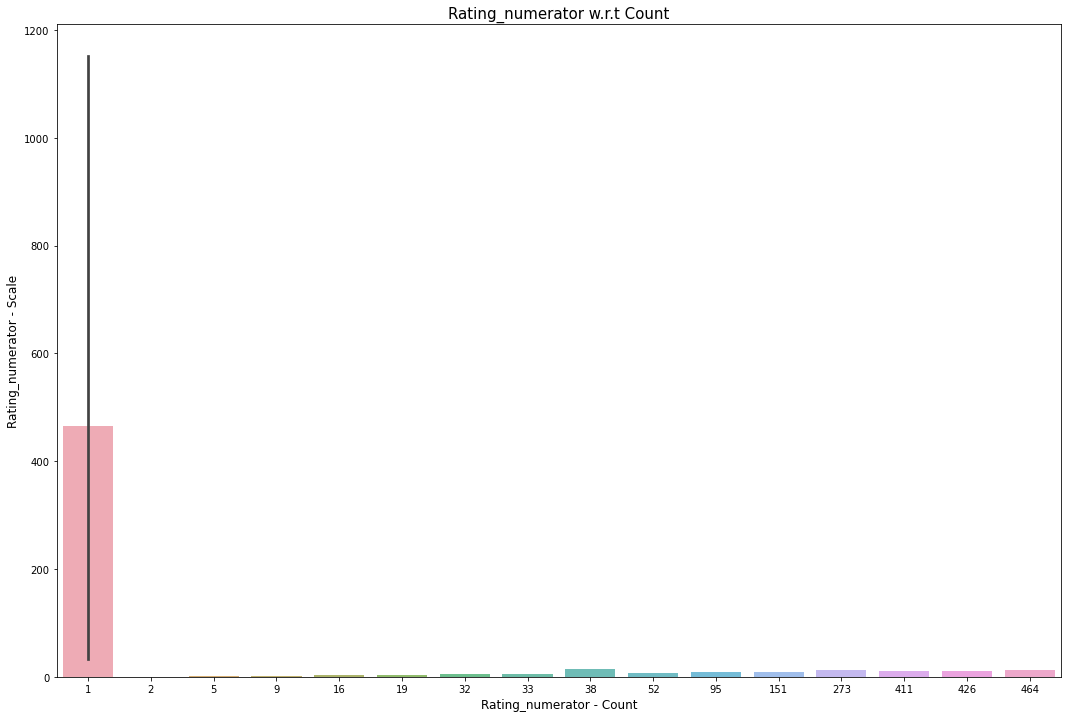

In [92]:
# Top rating_numerator values based on the count
cnt_srs = archive_clean['rating_numerator'].value_counts().head(20)
plt.figure(figsize=(18,12))
graph = sns.barplot(y=cnt_srs.index, x=cnt_srs.values, alpha=0.8)
plt.xlabel('Rating_numerator - Count', fontsize=12)
plt.ylabel('Rating_numerator - Scale', fontsize=12)
plt.title("Rating_numerator w.r.t Count", fontsize=15)
plt.show()
fig = graph.get_figure()
fig.savefig('rating_numerator.png')

Rating numerator is around 10

In [93]:
archive_clean[archive_clean['rating_denominator'] < 10].shape

(2, 28)

In [94]:
archive_clean[archive_clean['rating_denominator'] > 10].shape

(16, 28)

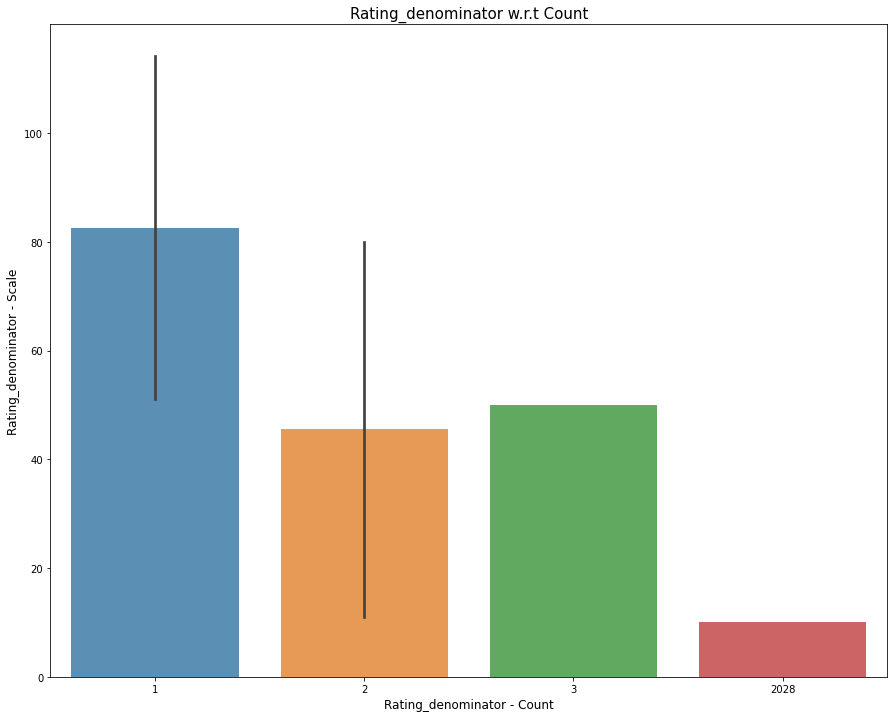

In [95]:
# Top rating_denominator values based on the count
cnt_srs = archive_clean['rating_denominator'].value_counts().head(30)
plt.figure(figsize=(15,12))
graph = sns.barplot(y=cnt_srs.index, x=cnt_srs.values, alpha=0.8)
plt.xlabel('Rating_denominator - Count', fontsize=12)
plt.ylabel('Rating_denominator - Scale', fontsize=12)
plt.title("Rating_denominator w.r.t Count", fontsize=15)
plt.show()
fig = graph.get_figure()
fig.savefig('rating_denominator.png')

2028 have denominator '10' while some have denominator rating more than or less than 10

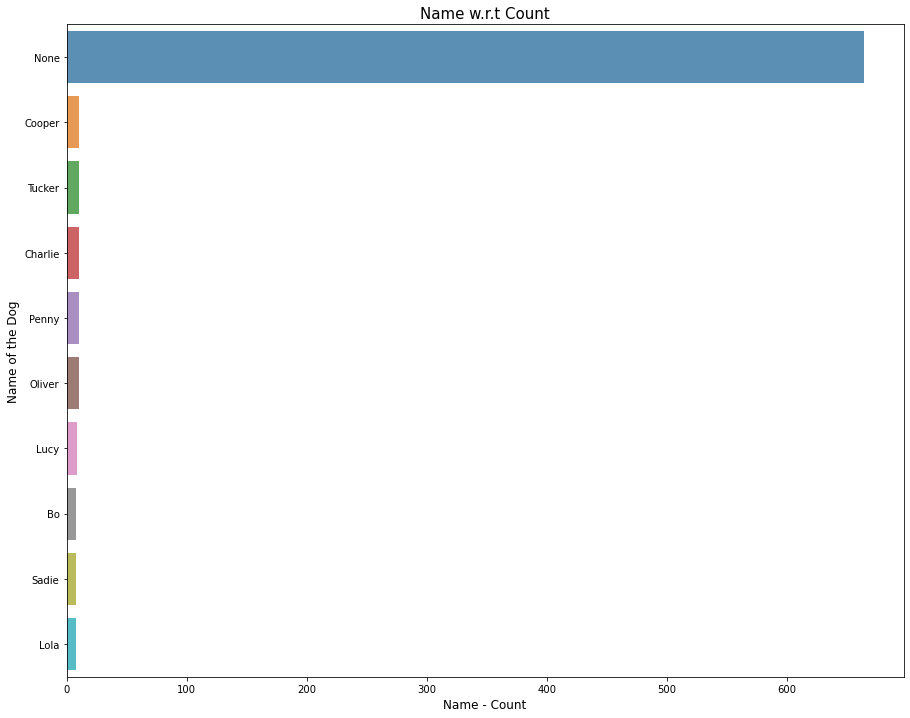

<Figure size 432x288 with 0 Axes>

In [105]:
# Top dog name values based on the count
cnt_srs = archive_clean['name'].value_counts().head(10)
plt.figure(figsize=(15,12))
sns.barplot(y=cnt_srs.index, x=cnt_srs.values, alpha=0.8)
plt.xlabel('Name - Count', fontsize=12)
plt.ylabel('Name of the Dog', fontsize=12)
plt.title("Name w.r.t Count", fontsize=15)
plt.show()
plt.savefig('Name wrt Count.png')

Majority of the dog names are 'None'

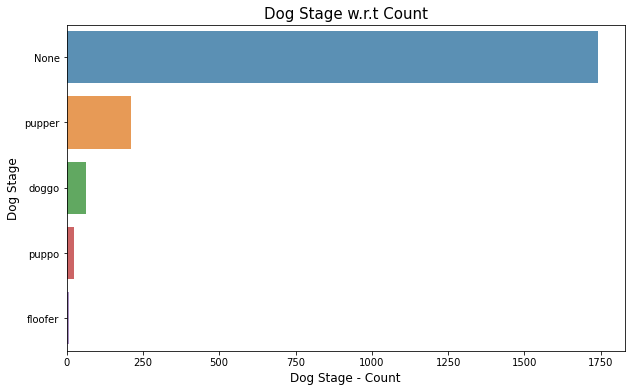

In [97]:
# Top Dog_stage values based on the count
cnt_srs = archive_clean['dog_stage'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(y=cnt_srs.index, x=cnt_srs.values, alpha=0.8)
plt.xlabel('Dog Stage - Count', fontsize=12)
plt.ylabel('Dog Stage', fontsize=12)
plt.title("Dog Stage w.r.t Count", fontsize=15)
plt.show()

Among other categories, pupper category is dominant.